# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
 -1
 -1
 -1
 -1
  1
 -1
  1
  1
  1
  ⋮
 -1
  1
  1
  1
  1
 -1
  1
  1
  1

### We create a function to visualize the data

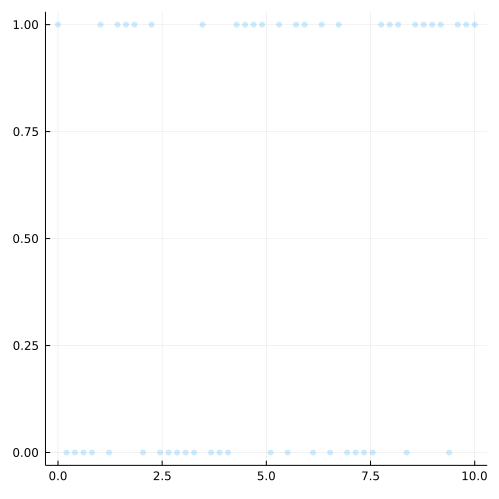

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.031672 seconds (1.82 M allocations: 103.793 MiB, 99.62% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.8288640935571727, 0.795035611188699, 0.751696303168907, 0.7014142095241273, 0.6532636738406234, 0.6186903992440974, 0.6028369420521047, 0.5996844935042794, 0.5997862665062038, 0.6030120444020195  …  0.7499693300699235, 0.8679633139368611, 0.9816396077497365, 1.074071244957142, 1.1375579480022502, 1.1711528460748148, 1.178459184886625, 1.1661057106089452, 1.1412429562393704, 1.1110182155953894], θ = [0.23660657561071374, 0.23761394746343348, 0.23885737097661625, 0.24023072775593912, 0.24147301173963728, 0.24231932796671612, 0.24269429281774502, 0.24276785805204026, 0.24276548827429462, 0.2426901969194796  …  0.23890579138448326, 0.23540364674732206, 0.2316872988721964, 0.2284488891197035, 0.22612561731404102, 0.22486675051574467, 0.2245904240131124, 0.22505711191998248, 0.2259884915457

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:14
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:40
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:46
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:20
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:03
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:53
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:45
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:39
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:35
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:31
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:28
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:26
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.26130686582276463, 0.11096354211967041, 0.3884035032257625, 0.6007838604252419, 0.6832605512413675, 0.7191195421776911, 0.6689146217166633, 0.5325557037876187, 0.32706695355300636, 0.037170419228436696  …  -0.6616148061457421, -0.3421326809013605, -0.02056143622711204, 0.3033987564276276, 0.6257139670793317, 0.8967498476149223, 1.1137953985928133, 1.2348886647458182, 1.3022439490081057, 1.3370553817961852]]
 [[-0.5895606116841173, -0.6472305966422717, -0.5918421451665162, -0.46806904049354003, -0.3343867138075524, -0.17797820108973855, -0.05432813692767418, 0.051966964757099526, 0.1189088534514749, 0.16159757179202608  …  0.6284200312404693, 0.7129532056701877, 0.8367365517555628, 1.0061863329422063, 1.139676067382122, 1.2925149681968058, 1.3286030775092188, 1.3435987399952662, 1.3070451245507393, 1.2063349403730932]]
 [[1.029800606885757, 0.7286456908979249, 0.47949639010180106, 0.3292459369859012, 0.21437455335854486, 0.154465552200

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

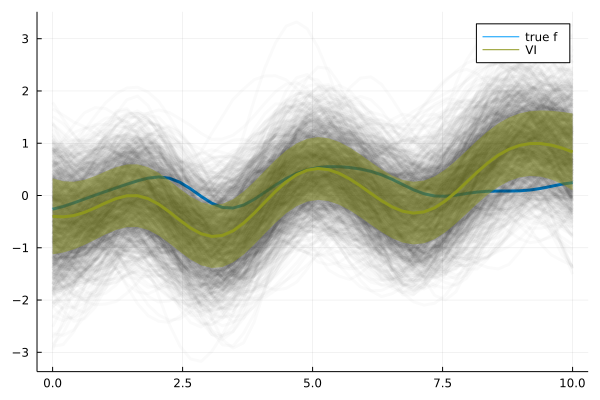

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

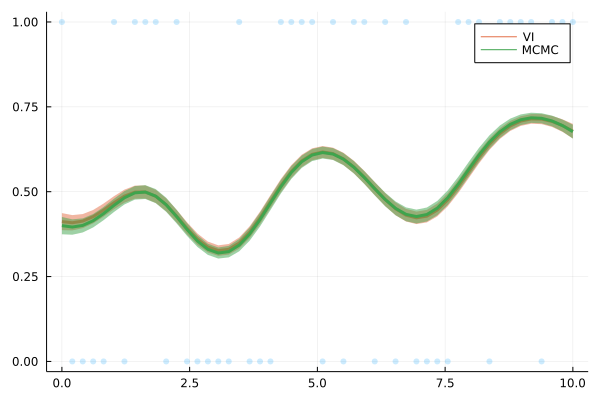

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*